# Drought Identification and Trend Analysis using Google Earth Engine (GEE) - Admin 1 Level

Author - Nitin Magima (edited by J. Sim for Rwanda)

Date - Oct 2024

Version - 1.0

[**Google Earth Engine**](https://earthengine.google.com/) is a public data archive of petabytes of historical satellite imagery and geospatial datasets. The advantage lies in its remarkable computation speed as processing is outsourced to Google servers. The platform provides a variety of constantly updated datasets; no download of raw imagery is required. While it is free of charge, one still needs to activate access to Google Earth Engine with a valid Google account.

The Jupyter Notebook uses the following [paper](https://www.mdpi.com/2071-1050/13/3/1042) to recreate the analysis for drought identification and trend analysis in Kenya using Google Earth Engine (GEE) for Python, follow these steps:

#### Data Collection

Obtain long-term satellite-derived precipitation data using the CHIRPS dataset available in GEE. This data will allow you to analyze drought conditions in Kenya. Use GEE to filter the CHIRPS dataset for the desired time period (e.g., 1981 to present).

#### Study Area Definition

Kenya's Boundaries: Define the study area by using Kenya's geographical boundaries.

#### Data Preprocessing

Extract Monthly Precipitation: Extract monthly CHIRPS precipitation data for the study area to calculate Standardized Precipitation Index (SPI) at different time scales (e.g., SPI1, SPI3, SPI6, SPI12).
Clip to Region: Clip the precipitation data to the Kenya boundaries to ensure that the analysis is focused solely on Kenya.

#### Calculate Standardized Precipitation Index (SPI)

SPI Calculation: Calculate SPI at different time scales (1-, 3-, 6-, and 12-month) for drought evaluation. Convert the CHIRPS precipitation data into SPI values by fitting a gamma distribution to each pixel's monthly time series.

#### Drought Characterization

Identify Drought Events: Use run theory to identify drought events based on SPI values. Define the drought duration, severity, and intensity by analyzing when SPI values fall below thresholds like -1.0 for moderate drought.
Identify drought duration (number of months below the threshold).
Calculate drought severity (sum of all SPI values during the drought).
Calculate drought intensity (severity divided by duration).

#### Trend Analysis

Mann-Kendall Test: Implement the Mann-Kendall trend test to determine trends in SPI values at annual, seasonal, and monthly time scales. This will help detect if there are increasing or decreasing trends in drought conditions.
Apply Sen’s slope estimator to understand the magnitude of trends.

#### EM-DAT Analysis

Use historical drought years from the [Emergency Events Database (EM-DAT)](https://www.emdat.be/) for comparison.


### DISCLAIMER

This is a set of scripts  shared for educational purposes only.  Anyone who uses this code or its
functionality or structure, assumes full liability and credits the author.

#### Map Disclaimer

The designations employed and the presentation of the material on this map do not imply the expression
of any opinion whatsoever on the part of the author concerning the legal status of any country, territory, city or area or of its authorities, or concerning the delimitation of its
frontiers or boundaries.


# Google Earth Engine Setup

### Install Geemap

In [ ]:
!pip install -U "geemap[workshop]"

### Import libraries

In [ ]:
!pip install pymannkendall

In [3]:
import ee
import geemap
import numpy as np
import pandas as pd
from scipy.stats import gamma, norm, kstest, probplot
import time
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown
import pymannkendall as mk

### Authenticate and initialize Earth Engine

You will need to create a [Google Cloud Project](https://console.cloud.google.com/projectcreate) and enable the [Earth Engine API](https://console.cloud.google.com/apis/api/earthengine.googleapis.com) for the project. You can find detailed instructions [here](https://book.geemap.org/chapters/01_introduction.html#earth-engine-authentication).

In [4]:
ee.Authenticate()

Update the project below.

In [5]:
ee.Initialize(project="bayesian-clustering-for-zoning")

## Initialize Map

In [6]:
# Creating a map
m = geemap.Map(center=[-1.94, 29.87], zoom=8)
m

Map(center=[-1.94, 29.87], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

# Define Analysis Boundaries

We use the following [crop calendar](https://fews.net/sites/default/files/styles/large_width_880/public/2023-03/seasonal-calendar-kenya.png?itok=0Wob_hCK) to select the regions and time periods to focus on.

We define boundaries for East/Iburasirazuba, Kigali City/Umujyi wa Kigali, North/Amajyaruguru, South/Amajyepfo, and West/Iburengerazuba. We use the [FAO GAUL: Global Administrative Unit Layers](https://data.apps.fao.org/catalog/dataset/global-administrative-unit-layers-gaul) for the analysis.

The Global Administrative Unit Layers (GAUL) compiles and disseminates the best available information on administrative units for all the countries in the world, providing a contribution to the standardization of the spatial dataset representing administrative units. The GAUL always maintains global layers with a unified coding system at country, first (e.g. departments), and second administrative levels (e.g. districts). Where data is available, it provides layers on a country by country basis down to third, fourth, and lowers levels.

In [7]:
# Load the FAO GAUL dataset for Kenya at administrative level 1
admin_level = 'level1'
country_name = 'Rwanda'
roi = ee.FeatureCollection(f"FAO/GAUL/2015/{admin_level}")
roi = roi.filter(ee.Filter.eq('ADM0_NAME', country_name))

# Print the available counties (ADM1_NAME) for verification
counties_list = roi.aggregate_array('ADM1_NAME').getInfo()
print(counties_list)

['East/Iburasirazuba', 'Kigali City/Umujyi wa Kigali', 'North/Amajyaruguru', 'South/Amajyepfo', 'West/Iburengerazuba']


In [8]:
# Set parameters
admin_level = 'level1'
country_name = 'Rwanda'

# Load the FAO GAUL dataset for Rwanda at administrative level 1
roi = ee.FeatureCollection(f"FAO/GAUL/2015/{admin_level}")
roi = roi.filter(ee.Filter.eq('ADM0_NAME', country_name))

# Print the available counties (ADM1_NAME) for verification
counties_list = roi.aggregate_array('ADM1_NAME').getInfo()
print("Available Regions:", counties_list)

# Filter each region by using `eq` filter instead of `inList`
east_df = roi.filter(ee.Filter.eq('ADM1_NAME', 'East/Iburasirazuba'))
city_df = roi.filter(ee.Filter.eq('ADM1_NAME', 'Kigali City/Umujyi wa Kigali'))
north_df = roi.filter(ee.Filter.eq('ADM1_NAME', 'North/Amajyaruguru'))
south_df = roi.filter(ee.Filter.eq('ADM1_NAME', 'South/Amajyepfo'))
west_df = roi.filter(ee.Filter.eq('ADM1_NAME', 'West/Iburengerazuba'))

# Add the regions as layers to the map
m.addLayer(east_df, {"color": "blue"}, "East/Iburasirazuba")
m.addLayer(city_df, {"color": "red"}, "Kigali City/Umujyi wa Kigali")
m.addLayer(north_df, {"color": "green"}, "North/Amajyaruguru")
m.addLayer(south_df, {"color": "yellow"}, "South/Amajyepfo")
m.addLayer(west_df, {"color": "orange"}, "West/Iburengerazuba")

# Display the map
m


Available Regions: ['East/Iburasirazuba', 'Kigali City/Umujyi wa Kigali', 'North/Amajyaruguru', 'South/Amajyepfo', 'West/Iburengerazuba']


Map(bottom=33421.0, center=[-1.94, 29.87], controls=(WidgetControl(options=['position', 'transparent_bg'], wid…

# Load CHIRPS Pentad Dataset

# Define Time Period

Rwanda has three separate seasons each for planting and harvesting, and two rain seasons. We will use these timelines to define the start and end dates for creating the relevant dekadal (10-day period) analysis from the CHIRPS pentad data.

- Planting seasons: March (A), June (B), early-September to late-October (C)
- Harvests: December to mid-February (A), June to late-August (B), September (C, a 'minor' harvest)
- Rainy seasons: early-September to end-November (A, short), and mid-February to early-May (B, long).


Based on this calendar, we'll use the start and end months for rainfall using the CHIRPS Pentad dataset ('UCSB-CHG/CHIRPS/PENTAD').

In [9]:
def monthly_sum_from_pentads(clipped_pentads, region_name, region, year, start_month, end_month):
    """
    Calculate monthly precipitation sums from CHIRPS pentads (5-day intervals) for a specified region and time period.

    Parameters:
    clipped_pentads (ee.ImageCollection): The CHIRPS pentad data clipped to the region of interest.
    region_name (str): Name of the region.
    region (ee.Geometry): Geometry of the region.
    year (int): The year for which monthly totals are to be created.
    start_month (int): The starting month of the period (1 to 12).
    end_month (int): The ending month of the period (1 to 12).

    Returns:
    list: A list of dictionaries containing monthly precipitation data for the specified range.
    """
    monthly_precip_data = []

    # Loop through the specified months to calculate monthly precipitation totals
    for month in range(start_month, end_month + 1):
        start_month_date = ee.Date.fromYMD(year, month, 1)
        end_month_date = start_month_date.advance(1, 'month')

        # Filter pentad data for the current month
        pentad_filtered = clipped_pentads.filterDate(start_month_date, end_month_date)

        # Sum all pentads to form the monthly total
        monthly_sum = pentad_filtered.sum() \
                                     .reduceRegion(
                                         reducer=ee.Reducer.mean(),
                                         geometry=region,
                                         scale=5000, # The value 5000 indicates a scale of 5000 meters per pixel. This means that the aggregation is done at a 5 km resolution, which is appropriate for regional analysis to balance between detail and computational efficiency.
                                         maxPixels=1e8 # Since the aggregation involves a large spatial area, setting a high value like 1e8 (100 million pixels) ensures that the reduction can handle large images without failing due to pixel count limits.
                                     )

        # Extract the value and add additional information
        precipitation_value = monthly_sum.get('precipitation').getInfo() if monthly_sum.get('precipitation') else None

        monthly_precip_data.append({
            'year': year,
            'month': month,
            'date': start_month_date.format().getInfo(),
            'region': region_name,
            'precipitation': precipitation_value
        })

    return monthly_precip_data

In [18]:
# Load the CHIRPS Pentad dataset
chirps_pentad = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD')

# Clip the CHIRPS pentad dataset for each region
chirps_pentad_east = chirps_pentad.filterBounds(east_df)
chirps_pentad_city = chirps_pentad.filterBounds(city_df)
chirps_pentad_north = chirps_pentad.filterBounds(north_df)
chirps_pentad_south = chirps_pentad.filterBounds(south_df)
chirps_pentad_west = chirps_pentad.filterBounds(west_df)


# Define Inputs

long_rains_start = 2  # February
long_rains_end = 5  # May
short_rains_start = 9  # September
short_rains_end = 11  # November
start_year = 2000
end_year = 2023

# Initialize empty lists to store results for long rains and short rains
east_long_rains_results = []
east_short_rains_results = []
city_long_rains_results = []
city_short_rains_results = []
north_long_rains_results = []
north_short_rains_results = []
south_long_rains_results = []
south_short_rains_results = []
west_long_rains_results = []
west_short_rains_results = []

In [15]:
east_long_rains_results

[]

In [51]:
#East

# Loop through each year from start_year to end_year
for year in range(start_year, end_year + 1):
    # Start timing for the current year
    start_time = time.time()
    print(f"Year {year} started...")

    # Long Rains (February to May)
    east_long_rains = monthly_sum_from_pentads(
        clipped_pentads=chirps_pentad_east,
        region_name="east",
        region=east_df,
        year=year,
        start_month=long_rains_start,
        end_month=long_rains_end
    )
    east_long_rains_results.extend(east_long_rains)

    # Short Rains (September to November)
    east_short_rains = monthly_sum_from_pentads(
        clipped_pentads=chirps_pentad_east,
        region_name="east",
        region=east_df,
        year=year,
        start_month=short_rains_start,
        end_month=short_rains_end
    )
    east_short_rains_results.extend(east_short_rains)

    # End timing for the current year
    end_time = time.time()
    elapsed_time = end_time - start_time
    minutes, seconds = divmod(elapsed_time, 60)

    print(f"Year {year} completed. Time taken: {int(minutes)} minutes and {int(seconds)} seconds.\n")

# Convert the results into pandas DataFrames
east_long_rains_df = pd.DataFrame(east_long_rains_results)
east_long_rains_df['Season'] = 'Long Rain'
east_short_rains_df = pd.DataFrame(east_short_rains_results)
east_short_rains_df['Season'] = 'Short Rain'

# Display the first few rows of the DataFrames
print("\nEast Long Rains:")
print(east_long_rains_df.head())

print("\nEast Short Rains:")
print(east_short_rains_df.head())

Year 2000 started...
Year 2000 completed. Time taken: 0 minutes and 5 seconds.

Year 2001 started...
Year 2001 completed. Time taken: 0 minutes and 4 seconds.

Year 2002 started...
Year 2002 completed. Time taken: 0 minutes and 4 seconds.

Year 2003 started...
Year 2003 completed. Time taken: 0 minutes and 4 seconds.

Year 2004 started...
Year 2004 completed. Time taken: 0 minutes and 3 seconds.

Year 2005 started...
Year 2005 completed. Time taken: 0 minutes and 3 seconds.

Year 2006 started...
Year 2006 completed. Time taken: 0 minutes and 3 seconds.

Year 2007 started...
Year 2007 completed. Time taken: 0 minutes and 3 seconds.

Year 2008 started...
Year 2008 completed. Time taken: 0 minutes and 3 seconds.

Year 2009 started...
Year 2009 completed. Time taken: 0 minutes and 2 seconds.

Year 2010 started...
Year 2010 completed. Time taken: 0 minutes and 2 seconds.

Year 2011 started...
Year 2011 completed. Time taken: 0 minutes and 2 seconds.

Year 2012 started...
Year 2012 completed

In [52]:
#city

# Loop through each year from start_year to end_year
for year in range(start_year, end_year + 1):
    # Start timing for the current year
    start_time = time.time()
    print(f"Year {year} started...")

    # Long Rains (February to May)
    city_long_rains = monthly_sum_from_pentads(
        clipped_pentads=chirps_pentad_city,
        region_name="city",
        region=city_df,
        year=year,
        start_month=long_rains_start,
        end_month=long_rains_end
    )
    city_long_rains_results.extend(city_long_rains)

    # Short Rains (September to November)
    city_short_rains = monthly_sum_from_pentads(
        clipped_pentads=chirps_pentad_city,
        region_name="city",
        region=city_df,
        year=year,
        start_month=short_rains_start,
        end_month=short_rains_end
    )
    city_short_rains_results.extend(city_short_rains)

    # End timing for the current year
    end_time = time.time()
    elapsed_time = end_time - start_time
    minutes, seconds = divmod(elapsed_time, 60)

    print(f"Year {year} completed. Time taken: {int(minutes)} minutes and {int(seconds)} seconds.\n")

# Convert the results into pandas DataFrames
city_long_rains_df = pd.DataFrame(city_long_rains_results)
city_long_rains_df['Season'] = 'Long Rain'
city_short_rains_df = pd.DataFrame(city_short_rains_results)
city_short_rains_df['Season'] = 'Short Rain'

# Display the first few rows of the DataFrames
print("\ncity Long Rains:")
print(city_long_rains_df.head())

print("\ncity Short Rains:")
print(city_short_rains_df.head())

Year 2000 started...
Year 2000 completed. Time taken: 0 minutes and 2 seconds.

Year 2001 started...
Year 2001 completed. Time taken: 0 minutes and 2 seconds.

Year 2002 started...
Year 2002 completed. Time taken: 0 minutes and 2 seconds.

Year 2003 started...
Year 2003 completed. Time taken: 0 minutes and 2 seconds.

Year 2004 started...
Year 2004 completed. Time taken: 0 minutes and 2 seconds.

Year 2005 started...
Year 2005 completed. Time taken: 0 minutes and 2 seconds.

Year 2006 started...
Year 2006 completed. Time taken: 0 minutes and 2 seconds.

Year 2007 started...
Year 2007 completed. Time taken: 0 minutes and 2 seconds.

Year 2008 started...
Year 2008 completed. Time taken: 0 minutes and 2 seconds.

Year 2009 started...
Year 2009 completed. Time taken: 0 minutes and 2 seconds.

Year 2010 started...
Year 2010 completed. Time taken: 0 minutes and 2 seconds.

Year 2011 started...
Year 2011 completed. Time taken: 0 minutes and 2 seconds.

Year 2012 started...
Year 2012 completed

In [53]:
#west

# Loop through each year from start_year to end_year
for year in range(start_year, end_year + 1):
    # Start timing for the current year
    start_time = time.time()
    print(f"Year {year} started...")

    # Long Rains (February to May)
    west_long_rains = monthly_sum_from_pentads(
        clipped_pentads=chirps_pentad_west,
        region_name="west",
        region=west_df,
        year=year,
        start_month=long_rains_start,
        end_month=long_rains_end
    )
    west_long_rains_results.extend(west_long_rains)

    # Short Rains (September to November)
    west_short_rains = monthly_sum_from_pentads(
        clipped_pentads=chirps_pentad_west,
        region_name="west",
        region=west_df,
        year=year,
        start_month=short_rains_start,
        end_month=short_rains_end
    )
    west_short_rains_results.extend(west_short_rains)

    # End timing for the current year
    end_time = time.time()
    elapsed_time = end_time - start_time
    minutes, seconds = divmod(elapsed_time, 60)

    print(f"Year {year} completed. Time taken: {int(minutes)} minutes and {int(seconds)} seconds.\n")

# Convert the results into pandas DataFrames
west_long_rains_df = pd.DataFrame(west_long_rains_results)
west_long_rains_df['Season'] = 'Long Rain'
west_short_rains_df = pd.DataFrame(west_short_rains_results)
west_short_rains_df['Season'] = 'Short Rain'

# Display the first few rows of the DataFrames
print("\nwest Long Rains:")
print(west_long_rains_df.head())

print("\nwest Short Rains:")
print(west_short_rains_df.head())

Year 2000 started...
Year 2000 completed. Time taken: 0 minutes and 2 seconds.

Year 2001 started...
Year 2001 completed. Time taken: 0 minutes and 2 seconds.

Year 2002 started...
Year 2002 completed. Time taken: 0 minutes and 2 seconds.

Year 2003 started...
Year 2003 completed. Time taken: 0 minutes and 2 seconds.

Year 2004 started...
Year 2004 completed. Time taken: 0 minutes and 2 seconds.

Year 2005 started...
Year 2005 completed. Time taken: 0 minutes and 2 seconds.

Year 2006 started...
Year 2006 completed. Time taken: 0 minutes and 2 seconds.

Year 2007 started...
Year 2007 completed. Time taken: 0 minutes and 2 seconds.

Year 2008 started...
Year 2008 completed. Time taken: 0 minutes and 2 seconds.

Year 2009 started...
Year 2009 completed. Time taken: 0 minutes and 2 seconds.

Year 2010 started...
Year 2010 completed. Time taken: 0 minutes and 2 seconds.

Year 2011 started...
Year 2011 completed. Time taken: 0 minutes and 2 seconds.

Year 2012 started...
Year 2012 completed

In [54]:
#north

# Loop through each year from start_year to end_year
for year in range(start_year, end_year + 1):
    # Start timing for the current year
    start_time = time.time()
    print(f"Year {year} started...")

    # Long Rains (February to May)
    north_long_rains = monthly_sum_from_pentads(
        clipped_pentads=chirps_pentad_north,
        region_name="north",
        region=north_df,
        year=year,
        start_month=long_rains_start,
        end_month=long_rains_end
    )
    north_long_rains_results.extend(north_long_rains)

    # Short Rains (September to November)
    north_short_rains = monthly_sum_from_pentads(
        clipped_pentads=chirps_pentad_north,
        region_name="north",
        region=north_df,
        year=year,
        start_month=short_rains_start,
        end_month=short_rains_end
    )
    north_short_rains_results.extend(north_short_rains)

    # End timing for the current year
    end_time = time.time()
    elapsed_time = end_time - start_time
    minutes, seconds = divmod(elapsed_time, 60)

    print(f"Year {year} completed. Time taken: {int(minutes)} minutes and {int(seconds)} seconds.\n")

# Convert the results into pandas DataFrames
north_long_rains_df = pd.DataFrame(north_long_rains_results)
north_long_rains_df['Season'] = 'Long Rain'
north_short_rains_df = pd.DataFrame(north_short_rains_results)
north_short_rains_df['Season'] = 'Short Rain'

# Display the first few rows of the DataFrames
print("\nnorth Long Rains:")
print(north_long_rains_df.head())

print("\nnorth Short Rains:")
print(north_short_rains_df.head())

Year 2000 started...
Year 2000 completed. Time taken: 0 minutes and 2 seconds.

Year 2001 started...
Year 2001 completed. Time taken: 0 minutes and 2 seconds.

Year 2002 started...
Year 2002 completed. Time taken: 0 minutes and 2 seconds.

Year 2003 started...
Year 2003 completed. Time taken: 0 minutes and 2 seconds.

Year 2004 started...
Year 2004 completed. Time taken: 0 minutes and 2 seconds.

Year 2005 started...
Year 2005 completed. Time taken: 0 minutes and 2 seconds.

Year 2006 started...
Year 2006 completed. Time taken: 0 minutes and 2 seconds.

Year 2007 started...
Year 2007 completed. Time taken: 0 minutes and 2 seconds.

Year 2008 started...
Year 2008 completed. Time taken: 0 minutes and 2 seconds.

Year 2009 started...
Year 2009 completed. Time taken: 0 minutes and 2 seconds.

Year 2010 started...
Year 2010 completed. Time taken: 0 minutes and 2 seconds.

Year 2011 started...
Year 2011 completed. Time taken: 0 minutes and 2 seconds.

Year 2012 started...
Year 2012 completed

In [55]:
#south

# Loop through each year from start_year to end_year
for year in range(start_year, end_year + 1):
    # Start timing for the current year
    start_time = time.time()
    print(f"Year {year} started...")

    # Long Rains (February to May)
    south_long_rains = monthly_sum_from_pentads(
        clipped_pentads=chirps_pentad_south,
        region_name="south",
        region=south_df,
        year=year,
        start_month=long_rains_start,
        end_month=long_rains_end
    )
    south_long_rains_results.extend(south_long_rains)

    # Short Rains (September to November)
    south_short_rains = monthly_sum_from_pentads(
        clipped_pentads=chirps_pentad_south,
        region_name="south",
        region=south_df,
        year=year,
        start_month=short_rains_start,
        end_month=short_rains_end
    )
    south_short_rains_results.extend(south_short_rains)

    # End timing for the current year
    end_time = time.time()
    elapsed_time = end_time - start_time
    minutes, seconds = divmod(elapsed_time, 60)

    print(f"Year {year} completed. Time taken: {int(minutes)} minutes and {int(seconds)} seconds.\n")

# Convert the results into pandas DataFrames
south_long_rains_df = pd.DataFrame(south_long_rains_results)
south_long_rains_df['Season'] = 'Long Rain'
south_short_rains_df = pd.DataFrame(south_short_rains_results)
south_short_rains_df['Season'] = 'Short Rain'

# Display the first few rows of the DataFrames
print("\nsouth Long Rains:")
print(south_long_rains_df.head())

print("\nsouth Short Rains:")
print(south_short_rains_df.head())

Year 2000 started...
Year 2000 completed. Time taken: 0 minutes and 2 seconds.

Year 2001 started...
Year 2001 completed. Time taken: 0 minutes and 2 seconds.

Year 2002 started...
Year 2002 completed. Time taken: 0 minutes and 2 seconds.

Year 2003 started...
Year 2003 completed. Time taken: 0 minutes and 2 seconds.

Year 2004 started...
Year 2004 completed. Time taken: 0 minutes and 2 seconds.

Year 2005 started...
Year 2005 completed. Time taken: 0 minutes and 2 seconds.

Year 2006 started...
Year 2006 completed. Time taken: 0 minutes and 2 seconds.

Year 2007 started...
Year 2007 completed. Time taken: 0 minutes and 2 seconds.

Year 2008 started...
Year 2008 completed. Time taken: 0 minutes and 2 seconds.

Year 2009 started...
Year 2009 completed. Time taken: 0 minutes and 2 seconds.

Year 2010 started...
Year 2010 completed. Time taken: 0 minutes and 2 seconds.

Year 2011 started...
Year 2011 completed. Time taken: 0 minutes and 2 seconds.

Year 2012 started...
Year 2012 completed

In [56]:
# Combine all three DataFrames into a single DataFrame
combined_df = pd.concat([
    east_long_rains_df,
    east_short_rains_df,
    city_long_rains_df,
    city_short_rains_df,
    west_long_rains_df,
    west_short_rains_df,
    north_long_rains_df,
    north_short_rains_df,
    south_long_rains_df,
    south_short_rains_df
])

combined_df.to_csv("/content/rwanda_admin1_precip.csv")

# Calculate Standardized Precipitation Index (SPI)

## SPI Definitions

* SPI1 (1-month scale)

Used to capture short-term monthly precipitation fluctuations and early warning of meteorological drought.

* SPI3 (3-month scale)

Useful for seasonal drought analysis, which helps in understanding the drought conditions over a quarterly period, closely related to agricultural impacts.

* SPI6 (6-month scale)

Provides insights into medium-term drought conditions, capturing both the end of one season and the start of another, which can influence soil moisture and crop yield over a longer period.

* SPI12 (12-month scale)

Used to assess long-term drought conditions, representing annual fluctuations and providing insights into the overall hydrological drought scenario, which can affect groundwater recharge and surface water availability.


## Selecting SPI Time Scales
Based on the above definitions we select the following time Scales for Long and Short Rains:

- Long Rains: March to June (4-month period) - We will use 1-month and 3-month SPI for long rains to understand short-term and medium-term droughts.
- Short Rains: October to December (3-month period) - We will use 1-month and 3-month SPI to capture variability within the shorter rainy season.

## Determining Gamma Distribution

What is a Gamma Distribution?

A gamma distribution is a type of statistical model used to describe data that are always positive and usually skewed, meaning most values are small but there can be a few large values. It's often used for things like rainfall, where:

- Many days have little or no rain, and
- A few days have a lot of rain.

This type of pattern creates a graph that has a high peak near the small values and a long tail extending to larger values. That’s what the gamma distribution looks like.

Why Do We Use Gamma Distribution for Rainfall?

- Always Positive: Rainfall cannot be negative; it either doesn’t rain or it rains some amount. The gamma distribution is great for representing only positive values.
- Right-Skewed Data: Most of the time, we have small amounts of rainfall, and occasionally, we get heavy rainfall. The gamma distribution is good for representing this kind of uneven distribution.
- Flexibility: The shape of the gamma distribution can change to fit different types of rainfall patterns, making it a very flexible tool for modeling different weather conditions.

The Gamma Distribution is the Standardized Precipitation Index (SPI) as a way to figure out if a place is having normal, dry, or wet weather compared to its history.

1. Modeling Historical Rainfall:

We use the gamma distribution to fit the historical rainfall data. This helps us understand what the usual rainfall is like for each month.

2. Comparing to Current Rainfall:

Once we have the gamma model of typical rainfall, we compare current rainfall to see how much it differs from the usual.
This comparison tells us if it is drier or wetter than normal, and by how much.

3. Getting SPI:

The final step is to convert this difference into a number called SPI, which tells us:
- If the SPI is negative, it means it’s drier than usual (possible drought).
- If the SPI is positive, it means it’s wetter than usual (possible flooding).

In [28]:
# Checking if all precipitation values are positive in each dataset
print("East Long Rains: All values positive? ", (east_long_rains_df['precipitation'] > 0).all())
print("East Short Rains: All values positive? ", (east_short_rains_df['precipitation'] > 0).all())

print("City Long Rains: All values positive? ", (city_long_rains_df['precipitation'] > 0).all())
print("City Short Rains: All values positive? ", (city_short_rains_df['precipitation'] > 0).all())

print("West Long Rains: All values positive? ", (west_long_rains_df['precipitation'] > 0).all())
print("West Short Rains: All values positive? ", (west_short_rains_df['precipitation'] > 0).all())

print("North Long Rains: All values positive? ", (north_long_rains_df['precipitation'] > 0).all())
print("North Short Rains: All values positive? ", (north_short_rains_df['precipitation'] > 0).all())

print("South Long Rains: All values positive? ", (south_long_rains_df['precipitation'] > 0).all())
print("South Short Rains: All values positive? ", (south_short_rains_df['precipitation'] > 0).all())

East Long Rains: All values positive?  True
East Short Rains: All values positive?  True
City Long Rains: All values positive?  True
City Short Rains: All values positive?  True
West Long Rains: All values positive?  True
West Short Rains: All values positive?  True
North Long Rains: All values positive?  True
North Short Rains: All values positive?  True
South Long Rains: All values positive?  True
South Short Rains: All values positive?  True


### Histograms

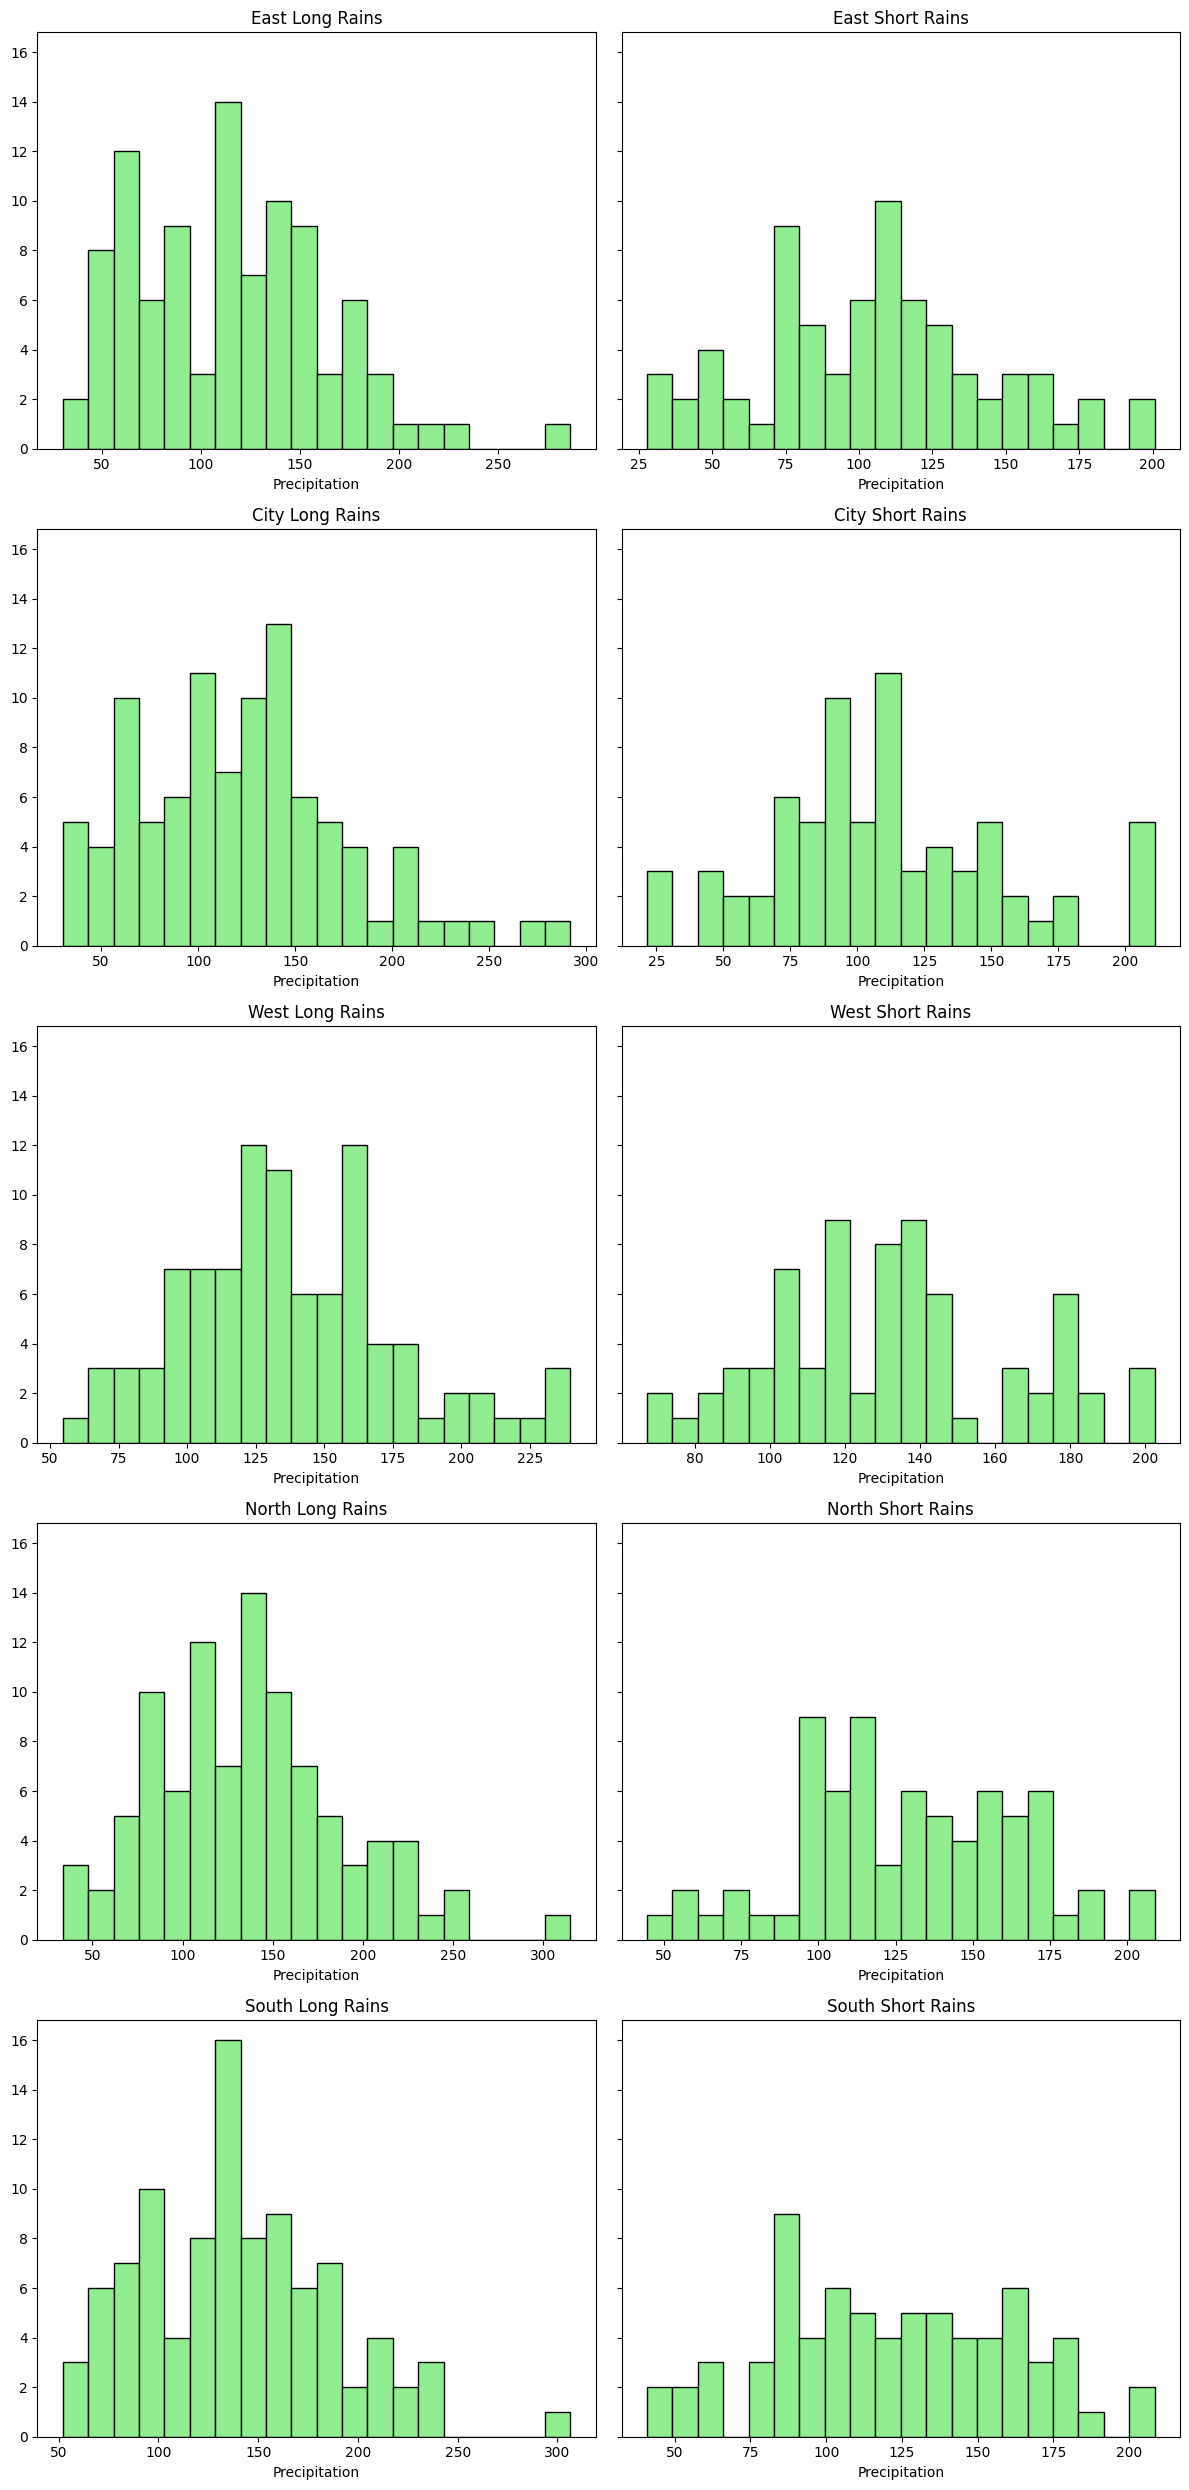

In [42]:
# Plot histograms for each dataset
fig, axes = plt.subplots(5, 2, figsize=(12, 25), sharey=True)

axes[0, 0].hist(east_long_rains_df['precipitation'], bins=20, color='lightgreen', edgecolor='black')
axes[0, 0].set_title('East Long Rains')
axes[0, 0].set_xlabel('Precipitation')

axes[0, 1].hist(east_short_rains_df['precipitation'], bins=20, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('East Short Rains')
axes[0, 1].set_xlabel('Precipitation')

axes[1, 0].hist(city_long_rains_df['precipitation'], bins=20, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('City Long Rains')
axes[1, 0].set_xlabel('Precipitation')

axes[1, 1].hist(city_short_rains_df['precipitation'], bins=20, color='lightgreen', edgecolor='black')
axes[1, 1].set_title('City Short Rains')
axes[1, 1].set_xlabel('Precipitation')

axes[2, 0].hist(west_long_rains_df['precipitation'], bins=20, color='lightgreen', edgecolor='black')
axes[2, 0].set_title('West Long Rains')
axes[2, 0].set_xlabel('Precipitation')

axes[2, 1].hist(west_short_rains_df['precipitation'], bins=20, color='lightgreen', edgecolor='black')
axes[2, 1].set_title('West Short Rains')
axes[2, 1].set_xlabel('Precipitation')

axes[3, 0].hist(north_long_rains_df['precipitation'], bins=20, color='lightgreen', edgecolor='black')
axes[3, 0].set_title('North Long Rains')
axes[3, 0].set_xlabel('Precipitation')

axes[3, 1].hist(north_short_rains_df['precipitation'], bins=20, color='lightgreen', edgecolor='black')
axes[3, 1].set_title('North Short Rains')
axes[3, 1].set_xlabel('Precipitation')

axes[4, 0].hist(south_long_rains_df['precipitation'], bins=20, color='lightgreen', edgecolor='black')
axes[4, 0].set_title('South Long Rains')
axes[4, 0].set_xlabel('Precipitation')

axes[4, 1].hist(south_short_rains_df['precipitation'], bins=20, color='lightgreen', edgecolor='black')
axes[4, 1].set_title('South Short Rains')
axes[4, 1].set_xlabel('Precipitation')

plt.tight_layout()
plt.show()

### Kolmogorov-Smirnov Test

Understanding the Kolmogorov-Smirnov Test:
The Kolmogorov-Smirnov test compares the empirical distribution of your data to a theoretical distribution (in this case, the gamma distribution).
The null hypothesis (H₀) of the KS test is that the data follows the specified distribution (in this case, gamma).
The alternative hypothesis (H₁) is that the data does not follow the specified distribution.

In the context of the Kolmogorov-Smirnov (KS) test, a p-value greater than 0.05 is typically desired when checking the fit of a distribution.

Interpreting the p-value:

- p-value > 0.05:
If the p-value is greater than 0.05, it means there is insufficient evidence to reject the null hypothesis.
In other words, the data fits the gamma distribution well. Therefore, we accept the null hypothesis and conclude that the gamma distribution is likely a good fit.

- p-value < 0.05:
If the p-value is less than 0.05, it means that there is significant evidence to reject the null hypothesis.
This suggests that the gamma distribution may not be a good fit for the data.

In [43]:
# Kolmogorov-Smirnov test to check if the gamma distribution fits each dataset.
def perform_ks_test(data):
    # Fit a gamma distribution to the data
    shape, loc, scale = gamma.fit(data, floc=0)  # floc=0 to ensure non-negative values

    # Perform Kolmogorov-Smirnov test
    test_stat, p_value = kstest(data, gamma(shape, loc, scale).cdf)

    # Print results
    if p_value > 0.05:
        print("The data fits the gamma distribution well (p-value: {:.4f}).".format(p_value))
    else:
        print("The gamma distribution may not be the best fit (p-value: {:.4f}).".format(p_value))

# Perform KS test for each dataset
print("\nEastern Northern Long Rains:")
perform_ks_test(east_long_rains_df['precipitation'].dropna())

print("\nEastern Northern Short Rains:")
perform_ks_test(east_short_rains_df['precipitation'].dropna())

print("\nEastern Northern Long Rains:")
perform_ks_test(city_long_rains_df['precipitation'].dropna())

print("\nEastern Northern Short Rains:")
perform_ks_test(city_short_rains_df['precipitation'].dropna())

print("\nEastern Northern Long Rains:")
perform_ks_test(west_long_rains_df['precipitation'].dropna())

print("\nEastern Northern Short Rains:")
perform_ks_test(west_short_rains_df['precipitation'].dropna())

print("\nEastern Northern Long Rains:")
perform_ks_test(north_long_rains_df['precipitation'].dropna())

print("\nEastern Northern Short Rains:")
perform_ks_test(north_short_rains_df['precipitation'].dropna())

print("\nEastern Northern Long Rains:")
perform_ks_test(south_long_rains_df['precipitation'].dropna())

print("\nEastern Northern Short Rains:")
perform_ks_test(south_short_rains_df['precipitation'].dropna())


Eastern Northern Long Rains:
The data fits the gamma distribution well (p-value: 0.5734).

Eastern Northern Short Rains:
The data fits the gamma distribution well (p-value: 0.4787).

Eastern Northern Long Rains:
The data fits the gamma distribution well (p-value: 0.6981).

Eastern Northern Short Rains:
The data fits the gamma distribution well (p-value: 0.7654).

Eastern Northern Long Rains:
The data fits the gamma distribution well (p-value: 0.9510).

Eastern Northern Short Rains:
The data fits the gamma distribution well (p-value: 0.6153).

Eastern Northern Long Rains:
The data fits the gamma distribution well (p-value: 0.8213).

Eastern Northern Short Rains:
The data fits the gamma distribution well (p-value: 0.7975).

Eastern Northern Long Rains:
The data fits the gamma distribution well (p-value: 0.7488).

Eastern Northern Short Rains:
The data fits the gamma distribution well (p-value: 0.9115).


### QQ Plots

A QQ plot, or Quantile-Quantile plot, is a graphical tool used to compare the distribution of a dataset with a theoretical distribution, such as the normal or gamma distribution. It's a provides a visual assessment of how well the dataset fits a chosen probability distribution. The QQ plot compares the quantiles of the dataset with the quantiles of the specified theoretical distribution.

If the data follows the theoretical distribution closely, the points on the plot will align approximately along a straight line. Deviations from this line indicate that the data does not conform well to the expected distribution.

In [45]:
# Visualize the Fit Using QQ Plots

# Assign Datasets
data_dict = {
    'East Long Rains': east_long_rains_df['precipitation'].dropna(),
    'East Short Rains': east_short_rains_df['precipitation'].dropna(),
    'City Long Rains': city_long_rains_df['precipitation'].dropna(),
    'City Short Rains': city_short_rains_df['precipitation'].dropna(),
    'West Long Rains': west_long_rains_df['precipitation'].dropna(),
    'West Short Rains': west_short_rains_df['precipitation'].dropna(),
    'North Long Rains': north_long_rains_df['precipitation'].dropna(),
    'North Short Rains': north_short_rains_df['precipitation'].dropna(),
    'South Long Rains': south_long_rains_df['precipitation'].dropna(),
    'South Short Rains': south_short_rains_df['precipitation'].dropna()
}

def interactive_qq_plot(region_time_scale):
    """
    Generates a QQ plot for the selected dataset using a gamma distribution.

    Parameters:
    region_time_scale (str): The key to select the dataset from the data dictionary.
    """
    # Extract the data series from the dictionary based on the selected region and time scale
    data = data_dict[region_time_scale]

    # Fit the gamma distribution
    shape, loc, scale = gamma.fit(data, floc=0)

    # Generate QQ plot
    plt.figure(figsize=(8, 6))
    probplot(data, dist="gamma", sparams=(shape, loc, scale), plot=plt)
    plt.title(f"QQ Plot to Check Gamma Fit: {region_time_scale}")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Ordered Values")
    plt.grid(True)
    plt.show()

# Create an interactive dropdown widget for selecting the region and time scale
interact(
    interactive_qq_plot,
    region_time_scale=Dropdown(
        options=list(data_dict.keys()),
        description='Select Region & Time Scale:',
        style={'description_width': 'initial'},
    )
)


interactive(children=(Dropdown(description='Select Region & Time Scale:', options=('East Long Rains', 'East Sh…

<function __main__.interactive_qq_plot(region_time_scale)>

## Calculate SPI

In [57]:
# Combine all datasets
all_rains_df = pd.concat([
    east_long_rains_df,
    east_short_rains_df,
    city_long_rains_df,
    city_short_rains_df,
    west_long_rains_df,
    west_short_rains_df,
    north_long_rains_df,
    north_short_rains_df,
    south_long_rains_df,
    south_short_rains_df
])

# Convert the 'date' column to datetime
all_rains_df['date'] = pd.to_datetime(all_rains_df['date'])

# Set the 'date' as the index for easier time series operations
all_rains_df.set_index('date', inplace=True)

# Sort the data by index
all_rains_df.sort_index(inplace=True)

def calculate_spi(precip_series, scale=1):
    """
    Calculate Standardized Precipitation Index (SPI) for a given precipitation series.

    Parameters:
    precip_series (pd.Series): Monthly precipitation data.
    scale (int): Time scale over which to calculate SPI (e.g., 1-month, 3-month).

    Returns:
    pd.Series: SPI values for the given precipitation series.
    """
    # Calculate rolling sum over the specified time scale
    precip_rolling = precip_series.rolling(window=scale).sum()

    # Drop NaN values resulting from the rolling operation
    precip_rolling = precip_rolling.dropna()

    # Fit a gamma distribution to the rolling sum data
    shape, loc, scale_param = gamma.fit(precip_rolling, floc=0)

    # Calculate cumulative distribution function (CDF) for gamma distribution
    gamma_cdf = gamma.cdf(precip_rolling, shape, loc=loc, scale=scale_param)

    # Convert gamma CDF to standard normal distribution to calculate SPI
    spi_values = norm.ppf(gamma_cdf)

    # Return the SPI values as a pandas Series with the same index as the rolling sum
    return pd.Series(spi_values, index=precip_rolling.index)

# Prepare the data by grouping it by region and calculating SPI for each region separately
regions = all_rains_df['region'].unique()
spi_results = {}

for region in regions:
    region_data = all_rains_df[all_rains_df['region'] == region]['precipitation']

    # Calculate 1-month SPI
    spi_1_month = calculate_spi(region_data, scale=1)
    spi_results[f'{region}_1_month'] = spi_1_month

    # Calculate 3-month SPI
    spi_3_month = calculate_spi(region_data, scale=3)
    spi_results[f'{region}_3_month'] = spi_3_month

# Convert SPI results to DataFrame
spi_results_df = pd.DataFrame(spi_results)

# Display SPI results for long rains and short rains
print("SPI Results for Long and Short Rains:")
print(spi_results_df.head())

SPI Results for Long and Short Rains:
            East/Iburasirazuba_1_month  East/Iburasirazuba_3_month  \
date                                                                 
2000-02-01                   -1.759533                         NaN   
2000-03-01                    0.300058                         NaN   
2000-04-01                   -0.345141                   -1.287825   
2000-05-01                   -1.025364                   -0.914688   
2000-09-01                   -2.508603                   -2.710913   

            north/Iburasirazuba_1_month  north/Iburasirazuba_3_month  \
date                                                                   
2000-02-01                    -2.071868                          NaN   
2000-03-01                    -0.617550                          NaN   
2000-04-01                    -0.258369                    -2.123554   
2000-05-01                    -1.166453                    -1.619400   
2000-09-01                    -2.514385

In [58]:
# Interactive plotting function
def plot_spi(region_time_scale):
    # Extract the SPI series based on the selected region and time scale
    spi_series = spi_results_df[region_time_scale].dropna()

    # Plot the SPI values
    plt.figure(figsize=(10, 6))
    plt.plot(spi_series.index, spi_series, color='blue', linestyle='-', marker='o', label='SPI')
    plt.axhline(y=0, color='black', linestyle='--')  # Reference line at SPI=0
    plt.axhline(y=-1, color='red', linestyle='--', label='Mild Drought (SPI=-1)')
    plt.axhline(y=-1.5, color='orange', linestyle='--', label='Moderate Drought (SPI=-1.5)')
    plt.axhline(y=-2, color='darkred', linestyle='--', label='Severe Drought (SPI=-2)')

    plt.xlabel('Date')
    plt.ylabel('SPI Value')
    plt.title(f'Standardized Precipitation Index (SPI) for {region_time_scale}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Get the list of region_time_scale options from the DataFrame columns
region_time_scale_options = spi_results_df.columns.tolist()

# Create a dropdown widget for selecting the region and time scale
interact(
    plot_spi,
    region_time_scale=Dropdown(
        options=region_time_scale_options,
        description='Select Region & Scale:',
        style={'description_width': 'initial'},
    )
)

interactive(children=(Dropdown(description='Select Region & Scale:', options=('East/Iburasirazuba_1_month', 'E…

<function __main__.plot_spi(region_time_scale)>

## Identify Drought Events

To characterize droughts, we need to analyze the SPI values calculated previously to identify distinct drought events. This involves analyzing when SPI values fall below a threshold, like -1.0, to determine the duration, severity, and intensity of each drought event.

Definitions:

- Drought Event: A period during which SPI is below a defined threshold (e.g., SPI < -1.0 for moderate drought).
- Drought Duration: The number of months during which the SPI value stays below the threshold.
- Drought Severity: The sum of all SPI values during the drought period.
- Drought Intensity: Severity divided by duration, indicating how intense the drought is on average.

In [59]:
def characterize_drought_events(spi_series, threshold=-1.0):
    """
    Identify and characterize drought events based on SPI values.

    Parameters:
    spi_series (pd.Series): Series of SPI values indexed by date.
    threshold (float): Threshold SPI value below which a drought event is identified (default: -1.0).

    Returns:
    pd.DataFrame: DataFrame containing drought events with columns for start, end, duration, severity, and intensity.
    """
    drought_events = []
    in_drought = False
    start_date = None
    severity = 0

    # Loop through each SPI value to identify drought events
    for date, spi_value in spi_series.items():
        if spi_value < threshold:
            # If we are not already in a drought, mark the start
            if not in_drought:
                in_drought = True
                start_date = date
                severity = spi_value
            else:
                # Accumulate severity if already in a drought
                severity += spi_value
        else:
            # If we exit a drought, calculate duration, severity, and intensity
            if in_drought:
                in_drought = False
                end_date = date
                duration = (end_date - start_date).days // 30  # Approximate duration in months
                intensity = severity / duration if duration > 0 else 0
                drought_events.append({
                    'start_date': start_date,
                    'end_date': end_date,
                    'duration_months': duration,
                    'severity': severity,
                    'intensity': intensity
                })

    # Handle the case where a drought is ongoing at the end of the series
    if in_drought:
        end_date = spi_series.index[-1]
        duration = (end_date - start_date).days // 30
        intensity = severity / duration if duration > 0 else 0
        drought_events.append({
            'start_date': start_date,
            'end_date': end_date,
            'duration_months': duration,
            'severity': severity,
            'intensity': intensity
        })

    # Convert to DataFrame
    return pd.DataFrame(drought_events)

In [60]:
# Identify drought events for each region and time scale
drought_characteristics = {}

for column in spi_results_df.columns:
    spi_series = spi_results_df[column].dropna()
    drought_characteristics[column] = characterize_drought_events(spi_series)

# Display drought characteristics for "East/Iburasirazuba" on a 1-month scale
print("Drought Characteristics for East/Iburasirazuba(1-Month Scale):")
print(drought_characteristics['east_1_month'])

# Display drought characteristics for "East/Iburasirazuba" on a 3-month scale
print("Drought Characteristics for East/Iburasirazuba (3-Month Scale):")
print(drought_characteristics['east_3_month'])

# Display drought characteristics for "Kigali City/Umujyi wa Kigali'" on a 1-month scale
print("Drought Characteristics for Kigali City/Umujyi wa Kigali' (1-Month Scale):")
print(drought_characteristics['city_1_month'])

# Display drought characteristics for "Kigali City/Umujyi wa Kigali'" on a 3-month scale
print("Drought Characteristics for Kigali City/Umujyi wa Kigali' (3-Month Scale):")
print(drought_characteristics['city_3_month'])

# Display drought characteristics for "North/Amajyaruguru" on a 1-month scale
print("Drought Characteristics for North/Amajyaruguru(1-Month Scale):")
print(drought_characteristics['north_1_month'])

# Display drought characteristics for "North/Amajyaruguru" on a 3-month scale
print("Drought Characteristics for North/Amajyaruguru (3-Month Scale):")
print(drought_characteristics['north_3_month'])

# Display drought characteristics for "South/Amajyepfo" on a 1-month scale
print("Drought Characteristics for South/Amajyepfo(1-Month Scale):")
print(drought_characteristics['south_1_month'])

# Display drought characteristics for "South/Amajyepfo" on a 3-month scale
print("Drought Characteristics for South/Amajyepfo (3-Month Scale):")
print(drought_characteristics['south_3_month'])

# Display drought characteristics for "West/Iburengerazuba" on a 1-month scale
print("Drought Characteristics for West/Iburengerazuba(1-Month Scale):")
print(drought_characteristics['west_1_month'])

# Display drought characteristics for "West/Iburengerazuba" on a 3-month scale
print("Drought Characteristics for West/Iburengerazuba (3-Month Scale):")
print(drought_characteristics['west_3_month'])

Drought Characteristics for East/Iburasirazuba(1-Month Scale):
   start_date   end_date  duration_months  severity  intensity
0  2000-02-01 2000-03-01                0 -1.759533   0.000000
1  2000-05-01 2000-10-01                5 -3.533967  -0.706793
2  2001-02-01 2001-03-01                0 -1.485716   0.000000
3  2002-02-01 2002-03-01                0 -1.021185   0.000000
4  2002-09-01 2002-10-01                1 -2.454896  -2.454896
5  2003-02-01 2003-03-01                0 -1.547386   0.000000
6  2004-05-01 2004-09-01                4 -1.140611  -0.285153
7  2005-02-01 2005-03-01                0 -1.249799   0.000000
8  2006-09-01 2006-10-01                1 -1.780804  -1.780804
9  2008-05-01 2008-09-01                4 -1.272887  -0.318222
10 2009-09-01 2009-10-01                1 -2.449790  -2.449790
11 2010-09-01 2010-10-01                1 -1.412052  -1.412052
12 2012-02-01 2012-03-01                0 -1.158066   0.000000
13 2013-02-01 2013-03-01                0 -1.227821   0

Note - The issue where drought durations exceed expected limits (e.g., durations exceeding 3 months for a "3-month SPI scale") arises from the way the drought characterization function is designed. Specifically, the function might be identifying prolonged drought events that span beyond a single season or multi-month drought events that are not being properly split when SPI values rise above the threshold.

Due to continuous negative SPI Values, the function currently identifies a drought event as continuing until the SPI rises above the threshold. If the SPI remains below the threshold for an extended period (even beyond a season), the function will count that entire period as a single drought event.

## Trend Analysis

The Mann-Kendall test is a non-parametric test used to identify trends in time series data. It is particularly useful for climate data, like SPI values, to determine if there's a significant increasing or decreasing trend in drought conditions over time. We will also use Sen’s slope estimator to determine the magnitude of the trends identified.

In [61]:
# Function to perform Mann-Kendall Test and Sen's Slope Estimation
def perform_trend_analysis(spi_series, time_scale):
    """
    Perform Mann-Kendall test and Sen's Slope Estimation for the given SPI series.

    Parameters:
    spi_series (pd.Series): Series of SPI values.
    time_scale (str): Time scale (e.g., 'annual', 'seasonal', 'monthly').

    Returns:
    dict: Dictionary containing trend, p-value, and Sen's slope.
    """
    # Drop NaN values
    spi_series = spi_series.dropna()

    # Perform Mann-Kendall Trend Test
    mk_result = mk.original_test(spi_series)

    # Extract trend, p-value, and Sen's slope
    trend = mk_result.trend
    p_value = mk_result.p
    sen_slope = mk_result.slope

    return {
        'time_scale': time_scale,
        'trend': trend,
        'p_value': p_value,
        'sen_slope': sen_slope
    }

In [62]:
# Applying the Mann-Kendall Test and Sen's Slope Estimation
trend_analysis_results = {}

# Perform trend analysis for different time scales
time_scales = {
    'east_1_month': 'monthly',
    'east_3_month': 'seasonal',
    'city_1_month': 'monthly',
    'city_3_month': 'seasonal',
    'north_1_month': 'monthly',
    'north_3_month': 'seasonal',
    'south_1_month': 'monthly',
    'south_3_month': 'seasonal',
    'west_1_month': 'monthly',
    'west_3_month': 'seasonal'
}

# Loop through the SPI columns and apply trend analysis
for column, time_scale in time_scales.items():
    spi_series = spi_results_df[column]
    trend_analysis_results[column] = perform_trend_analysis(spi_series, time_scale)

# Convert results to DataFrame for better visualization
trend_analysis_df = pd.DataFrame(trend_analysis_results).T

# Display the trend analysis results
print("Trend Analysis Results (Mann-Kendall Test and Sen's Slope):")
print(trend_analysis_df)

Trend Analysis Results (Mann-Kendall Test and Sen's Slope):
              time_scale       trend   p_value sen_slope
east_1_month     monthly    no trend  0.543423  0.000934
east_3_month    seasonal    no trend  0.297527  0.001706
city_1_month     monthly    no trend  0.582295  0.000932
city_3_month    seasonal    no trend  0.959905 -0.000106
north_1_month    monthly    no trend   0.20846     0.002
north_3_month   seasonal  increasing  0.039288  0.003086
south_1_month    monthly    no trend  0.202567  0.002141
south_3_month   seasonal  increasing  0.011125   0.00403
west_1_month     monthly    no trend   0.23979  0.001922
west_3_month    seasonal    no trend  0.085864  0.002681
